In [2]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as mticker
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
from datetime import date
import matplotlib
#print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

In [3]:
WBC=OrderedDict([
    ('eac', {'region':[145-360,174-360,-48,-20], 'x':slice(145-360,174-360),
                    'y': slice(-48,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [5]:
font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)

In [ ]:
# save variables
PV_DS.to_netcdf('PV_DS_whole_good')
PV_DS_mean.to_netcdf('PV_DS_mean_gsgood')
PV_var.to_netcdf('PV_DS_var_gsgood')

In [19]:
# open ncfiles
PV_DS=xr.open_dataarray('PV_DS_whole_good')
PV_DS_mean=xr.open_dataarray('PV_DS_mean_gsgood')
PV_var=xr.open_dataarray('PV_DS_var_gsgood')

# Downstream potential vorticity 

In [6]:
ekey='01deg'
expt=exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
offset = exptdata.exptdict[ekey]['offset']
time_units=exptdata.exptdict[ekey]['time_units']
region=WBC['gs']['region']
gsx=WBC['gs']['x']
gsy=WBC['gs']['y']

In [7]:
def input_pv(time):
    print('loading u...')
    u = cc.get_nc_variable(expt,'ocean.nc','u',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=gsx)\
                                 .sel(yu_ocean=gsy)\
                                 .sel(time=time)
    print('loading v...')
    v = cc.get_nc_variable(expt,'ocean.nc','v',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xu_ocean=gsx)\
                                 .sel(yu_ocean=gsy)\
                                 .sel(time=time)
    print('loading w...')
    w=cc.get_nc_variable(expt,'ocean.nc','wt',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=slice(-82, -62))\
                                 .sel(yt_ocean=slice(22,46))\
                                 .sel(time=time)
    print('loading pv...')
    pv = cc.get_nc_variable(expt,'ocean.nc','vert_pv',use_cache=True,
                                 n=n_files,time_units=time_units,offset=offset)\
                                 .sel(xt_ocean=slice(-82, -62))\
                                 .sel(yt_ocean=slice(22,46))\
                                 .sel(time=time)
    return u,v,w,pv

## Good separation period (1985-2009)

In [8]:
time=slice('1985-01-01','2009-01-01')
u,v,w,pv=input_pv(time)

loading u...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
loading v...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
loading w...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl
loading pv...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_vert_pv_None_days-since-0001-01-01_None_False.pkl


In [12]:
d=400
pv_diff=(pv.isel(time=-1)-pv.isel(time=0)).sel(st_ocean=d,method='nearest')
pv_tend=pv_diff/(date.toordinal(date(2009,1,1))-date.toordinal(date(1985,1,1))*24*3600)

Text(0.5, 1.0, 'PV tendecy')

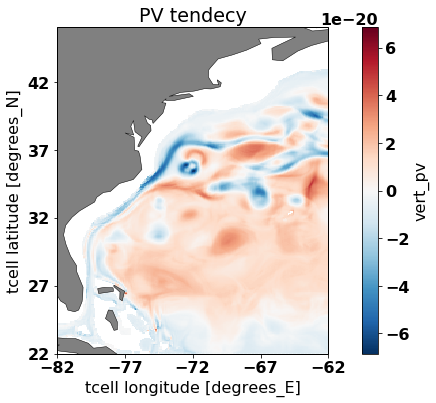

In [14]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(gsx.start,gsx.stop+1,5),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(gsy.start,gsy.stop+1,5),crs=ccrs.PlateCarree())
p1=pv_tend.sel(xt_ocean=gsx).sel(yt_ocean=gsy).plot()
plt.title('PV tendecy')

In [16]:
d=400
umean=u.mean('time').sel(st_ocean=d,method='nearest')
vmean=v.mean('time').sel(st_ocean=d,method='nearest')
X,Y=np.meshgrid(umean['xu_ocean'].values,umean['yu_ocean'].values)

Text(0, 0.5, 'Latitude')

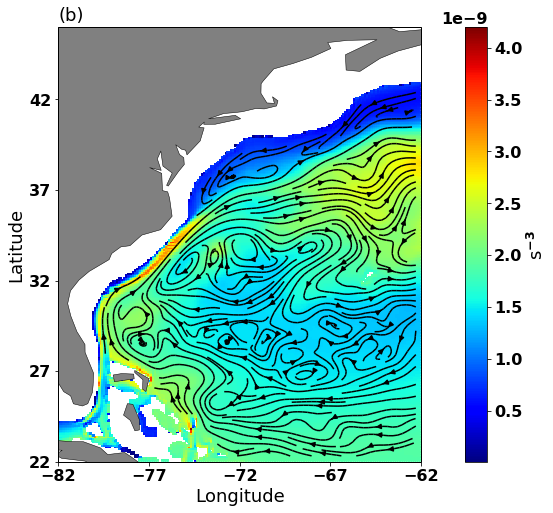

In [17]:
fig=plt.figure(figsize=(16,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
ax0.streamplot(X,Y,umean.values,vmean.values,density=2.5,color='k',linewidth=1.5)
p=pv.mean('time').sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=False)#,vmax=2.5e-9,vmin=0)
#plt.title('time-mean PV and streamline')
cb=plt.colorbar(p)
cb.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
#savefigure('pvandsl_gfs01')

## Whole PV
\begin{equation}
\overline{\textbf{u}\cdot\nabla q}=\overline{u\frac{\partial q}{\partial x}+ v \frac{\partial q}{\partial y}+w \frac{\partial q}{\partial z}}
\end{equation}

In [10]:
def whole_pv(u,v,w,pv):
    # load and trim grid data
    ysize=pv.shape[2]
    xsize=pv.shape[3]
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxu=grid.dxu.sel(xu_ocean=slice(-82, -62))\
            .sel(yu_ocean=slice(22,46))[:,0:-1]
    dxdx=dxu.values[:,0:-1]+dxu.values[:,1:]
    dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
    dx3d=np.tile(dxdx_snmean,(75,1,1))

    dyu=grid.dyu.sel(xu_ocean=slice(-82, -62))\
            .sel(yu_ocean=slice(22,46))[1:-1,:]
    dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
    dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
    dy3d=np.tile(dy_wemean,(75,1,1))  

    z=u.st_ocean.values
    dz=z[1:]-z[0:-1]
    dzdz=dz[1:]+dz[0:-1]
    dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
    dz3d=np.transpose(dz3d,(2,0,1))
    pv_ds=np.zeros((73,ysize-2,xsize-2))
    T=len(u.time)
    for i in range(0,T):
        print('opening file',str(i+1),'in'+str(T))
        u1=u.isel(time=i)
        v1=v.isel(time=i)
        w1=w.isel(time=i)
        pv1=pv.isel(time=i)
        
        #u*(dq/dx)
        dq=pv1.values[:,:,2:]-pv1.values[:,:,0:-2]
        unew=u1[:,:,0:-1]
        uu=1/2*(unew.values[:,:,0:-1]+unew.values[:,:,1:])
        uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
        udq_dx=uu_snmean*(dq/dx3d)
        Udq_dx=xr.DataArray(udq_dx,coords=[pv1['st_ocean'],pv1['yt_ocean'],pv1['xt_ocean'][1:-1]])
        #v*(dq/dy)
        pvy=pv1[:,:,1:]
        dqy=pvy.values[:,2:,:]-pvy.values[:,0:-2,:]
        vnew=v1[:,1:-1,:]
        vv=1/2*(vnew.values[:,0:-1,:]+vnew.values[:,1:,:])
        vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
        vdq_dy=vv_wemean*(dqy/dy3d)
        Vdq_dy=xr.DataArray(vdq_dy,coords=[pv1['st_ocean'],pv1['yt_ocean'][1:-1],pv1['xt_ocean'][1:]])
        #w*(dq/dz)
        wnew=w1[:,1:-1,1:-1]
        qz=pv1[:,1:-1,1:-1]
        #dqz=qz.values[1:,:,:]-qz.values[0:-1,:,:]
        dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
        w_mean=1/2*(wnew.values[0:-2,:,:]+wnew.values[1:-1,:,:])
        wdq_dz=w_mean*(dqz/dz3d)
        Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
        #speed=np.sqrt(uu_snmean**2+vv_wemean[:,:,1:]**2)
        pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]
        pv_ds=pv_ds+pv_downstream.values/T
    PV_DS=xr.DataArray(pv_ds,coords=[pv1['st_ocean'][1:-1],pv1['yt_ocean'][1:-1],pv1['xt_ocean'][1:-1]])
    return PV_DS

In [18]:
PV_DS=whole_pv(u,v,w,pv)

Text(0.5, 1.0, 'Whole PV change')

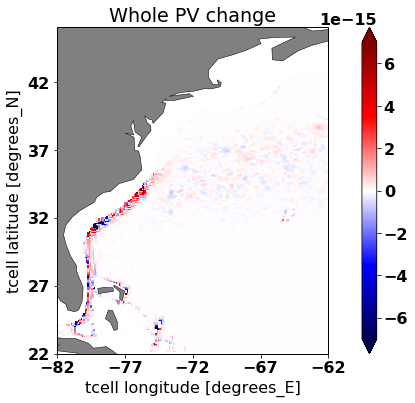

In [21]:
d=400
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(gsx.start,gsx.stop+1,5),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(gsy.start,gsy.stop+1,5),crs=ccrs.PlateCarree())
p1=PV_DS.sel(st_ocean=d,method='nearest').sel(xt_ocean=gsx).sel(yt_ocean=gsy).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15)
plt.title('Whole PV change')

In [25]:
U10=u.mean('time')
V10=v.mean('time')
U10_sl=U10.sel(st_ocean=d,method='nearest')
V10_sl=V10.sel(st_ocean=d,method='nearest')
X,Y=np.meshgrid(U10_sl['xu_ocean'].values,V10_sl['yu_ocean'].values)

## Downstream pv (mean flow)
\begin{equation}
\overline{\textbf{u}}\cdot\nabla \overline{q}=\overline{u}\frac{\partial \overline{q}}{\partial x}+\overline{v}\frac{\partial\overline{q}}{\partial y}+\overline{w}\frac{\partial \overline{q}}{\partial z}
\end{equation}

## PV variability
\begin{equation}
\overline{\textbf{u}'\cdot\nabla q'}=\overline{\textbf{u}\cdot\nabla q}-\overline{\textbf{u}}\cdot\nabla\overline{q}
\end{equation}

In [22]:
def meands_pv_mf(u,v,w,pv):
    zsize=pv.shape[1]
    ysize=pv.shape[2]
    xsize=pv.shape[3]
    u=u.mean('time')
    v=v.mean('time')
    w=w.mean('time')
    pv=pv.mean('time')
    grid = xr.open_dataset('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf/output120/ocean/ocean_grid.nc')
    dxu=grid.dxu.sel(xu_ocean=gsx)\
            .sel(yu_ocean=gsy)[:,0:-1]
    dxdx=dxu.values[:,0:-1]+dxu.values[:,1:]
    dxdx_snmean=1/2*(dxdx[0:-1,:]+dxdx[1:,:])
    dx3d=np.tile(dxdx_snmean,(zsize,1,1))

    dyu=grid.dyu.sel(xu_ocean=gsx)\
            .sel(yu_ocean=gsy)[1:-1,:]
    dydy=dyu.values[0:-1,:]+dyu.values[1:,:]
    dy_wemean=1/2*(dydy[:,0:-1]+dydy[:,1:])
    dy3d=np.tile(dy_wemean,(zsize,1,1))  

    z=u.st_ocean.values
    dz=z[1:]-z[0:-1]
    dzdz=dz[1:]+dz[0:-1]
    dz3d=np.tile(dzdz,(ysize-2,xsize-2,1))
    dz3d=np.transpose(dz3d,(2,0,1))
    
    #u*(dq/dx)
    dq=pv.values[:,:,2:]-pv.values[:,:,0:-2]
    unew=u[:,:,0:-1]
    uu=1/2*(unew.values[:,:,0:-1]+unew.values[:,:,1:])
    uu_snmean=1/2*(uu[:,0:-1,:]+uu[:,1:,:])
    udq_dx=uu_snmean*(dq/dx3d)
    Udq_dx=xr.DataArray(udq_dx,coords=[pv['st_ocean'],pv['yt_ocean'],pv['xt_ocean'][1:-1]])
    #v*(dq/dy)
    pvy=pv[:,:,1:]
    dqy=pvy.values[:,2:,:]-pvy.values[:,0:-2,:]
    vnew=v[:,1:-1,:]
    vv=1/2*(vnew.values[:,0:-1,:]+vnew.values[:,1:,:])
    vv_wemean=1/2*(vv[:,:,0:-1]+vv[:,:,1:])
    vdq_dy=vv_wemean*(dqy/dy3d)
    Vdq_dy=xr.DataArray(vdq_dy,coords=[pv['st_ocean'],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:]])
    #w*(dq/dz)
    wnew=w[:,1:-1,1:-1]
    qz=pv[:,1:-1,1:-1]
    #dqz=qz.values[1:,:,:]-qz.values[0:-1,:,:]
    dqz=qz.values[0:-2,:,:]-qz.values[2:,:,:]
    w_mean=1/2*(wnew.values[0:-2,:,:]+wnew.values[1:-1,:,:])
    #w_mean=1/2*(wnew.values[0:-1,:,:]+wnew.values[1:,:,:])
    wdq_dz=w_mean*(dqz/dz3d)
    Wdq_dz=xr.DataArray(wdq_dz,coords=[qz['st_ocean'][1:-1],qz['yt_ocean'],qz['xt_ocean']])
    #speed=np.sqrt(uu_snmean[:,1:-1,:]**2+vv_wemean[:,:,1:]**2)
    pv_downstream=(Udq_dx+Vdq_dy+Wdq_dz)#/speed[0:-1,:,:]

    PV_DS_mean=xr.DataArray(pv_downstream,coords=[pv['st_ocean'][1:-1],pv['yt_ocean'][1:-1],pv['xt_ocean'][1:-1]])
    return PV_DS_mean

In [26]:
PV_DS_mean=meands_pv_mf(u,v,w,pv)
PV_var=PV_DS-PV_DS_mean

In [23]:
z1=PV_DS_mean.sel(st_ocean=d,method='nearest').st_ocean.values
x1=PV_DS_mean.sel(xt_ocean=-74,method='nearest').xt_ocean.values

In [24]:
z=PV_DS_mean.st_ocean.values
y=PV_DS_mean.yt_ocean.values

Text(0, 0.5, 'S$^{-3}$')

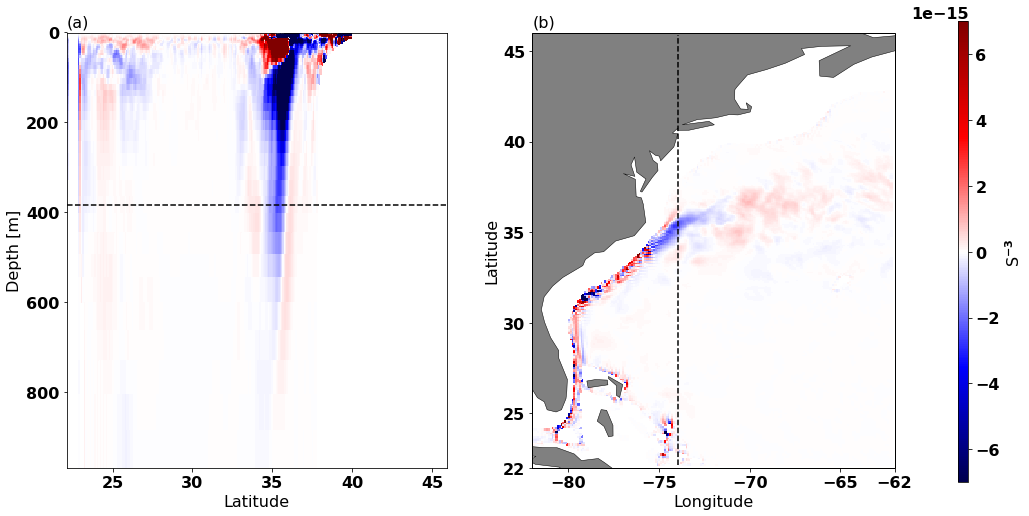

In [25]:
d=400
fig=plt.figure(figsize=(15,8))
ax=plt.subplot(1,2,1)
PV_DS_mean.sel(xt_ocean=-74,method='nearest').sel(st_ocean=slice(0,1000)).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,yincrease=False,add_colorbar=False)
plt.plot(y,np.tile(z1,len(y)),'k--')
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=16)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent([-82,-62,22,46],crs=ccrs.PlateCarree())
ax.set_xticks([-80,-75,-70,-65,-62],crs=ccrs.PlateCarree())
ax.set_yticks([22,25,30,35,40,45],crs=ccrs.PlateCarree())
p1=PV_DS_mean.sel(st_ocean=d,method='nearest').sel(xt_ocean=slice(-82,-62)).sel(yt_ocean=slice(22,46)).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15,add_colorbar=False)
plt.plot(np.tile(x1,len(y)),y,'k--')
plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=16)


ax3 = plt.axes([0.95,0.1,0.01,0.8])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('S$^{-3}$',fontsize=16)
#savefigure('GSslices')

In [12]:
PV_DS_mean['LON']=PV_DS_mean['xt_ocean']+360
PV_var['LON']=PV_var['xt_ocean']+360
PV_DS['LON']=PV_DS['xt_ocean']+360

In [13]:
land=cft.NaturalEarthFeature('physical','land','110m',
                            edgecolor='black',facecolor='gray',
                            linewidth=0.5)

In [14]:
d=400
umean=u.mean('time').sel(st_ocean=d,method='nearest')
vmean=v.mean('time').sel(st_ocean=d,method='nearest')
X,Y=np.meshgrid(umean['xu_ocean'].values,umean['yu_ocean'].values)

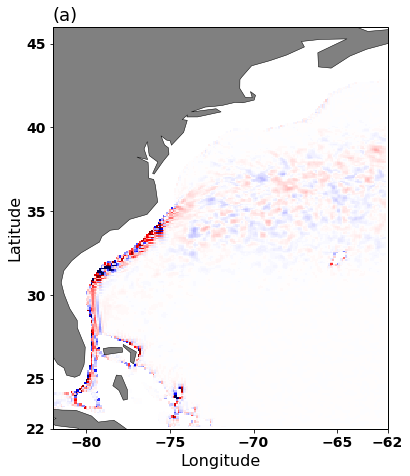

In [19]:
fig=plt.figure(figsize=(6,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
PV_DS.sel(st_ocean=d,method='nearest')\
          .plot(x='LON',y='yt_ocean',
                cmap='seismic',vmin=-5e-15,vmax=5e-15,add_colorbar=False)
#ax0.streamplot(X,Y,umean.values,vmean.values,density=2.5,color='k',linewidth=1.5)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)
savefigure('dspvcom_GFS_good_whole')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


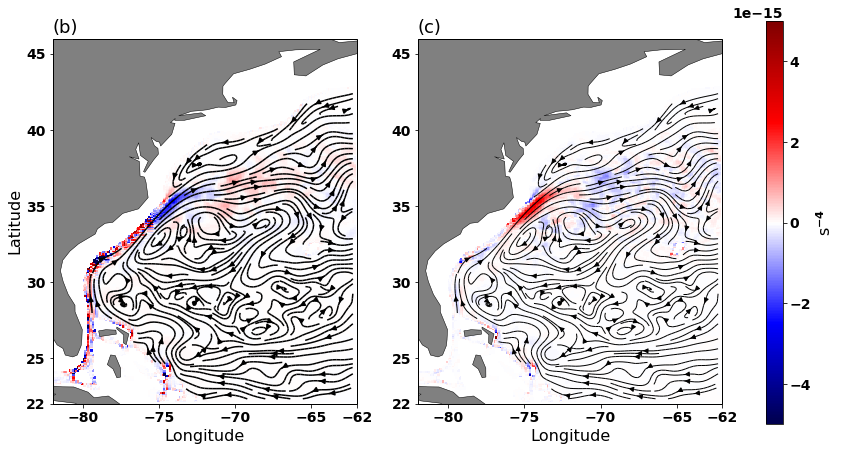

In [18]:
d=400
fig=plt.figure(figsize=(12,8))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
PV_DS_mean.sel(st_ocean=d,method='nearest')\
          .plot(x='LON',y='yt_ocean',
                cmap='seismic',vmin=-5e-15,vmax=5e-15,add_colorbar=False)
ax0.streamplot(X,Y,umean.values,vmean.values,density=2.5,color='k',linewidth=1.5)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)


ax0=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_extent([-82,-62, 22,46], crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks([-80,-75,-70,-65,-62], crs=ccrs.PlateCarree())
ax0.set_yticks([22,25,30,35,40,45], crs=ccrs.PlateCarree())
p1=PV_var.sel(st_ocean=d,method='nearest')\
         .plot(x='LON',y='yt_ocean',cmap='seismic',vmin=-5e-15,vmax=5e-15,add_colorbar=False)
ax0.streamplot(X,Y,umean.values,vmean.values,density=2.5,color='k',linewidth=1)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('',fontsize=16)
plt.title('')
plt.title('(c)',loc='left',fontsize=18)

cbar_ax=fig.add_axes([0.95,0.15,0.02,0.7])
cb=plt.colorbar(p1,cax=cbar_ax)
cb.ax.set_ylabel('s$^{-4}$',fontsize=16)
savefigure('dspvcom_GFS_good')

## Bad separation period (2009-2017)

In [32]:
PV_DS=xr.open_dataarray('PV_DS_whole_bad')
PV_DS_mean=xr.open_dataarray('PV_DS_mean_bad')
PV_var=xr.open_dataarray('PV_DS_var_bad')

In [33]:
time=slice('2009-01-01','2018-01-01')
u,v,w,pv=input_pv(time)

loading u...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
loading v...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
loading w...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl
loading pv...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_vert_pv_None_days-since-0001-01-01_None_False.pkl


In [34]:
d=400
pv_diff=(pv.isel(time=-1)-pv.isel(time=0)).sel(st_ocean=d,method='nearest')
pv_tend=pv_diff/(date.toordinal(date(2009,1,1))-date.toordinal(date(1985,1,1))*24*3600)

Text(0.5, 1.0, 'PV tendency')

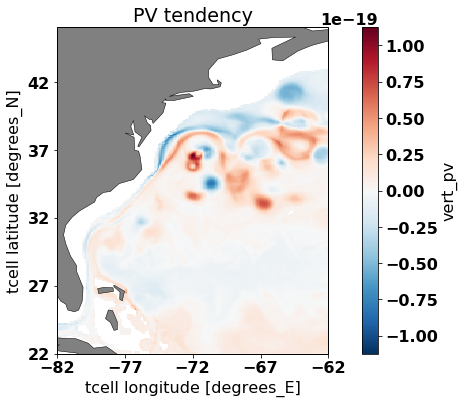

In [36]:
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(gsx.start,gsx.stop+1,5),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(gsy.start,gsy.stop+1,5),crs=ccrs.PlateCarree())
p1=pv_tend.sel(xt_ocean=gsx).sel(yt_ocean=gsy).plot()
plt.title('PV tendency')

In [37]:
umean=u.mean('time').sel(st_ocean=d,method='nearest')
vmean=v.mean('time').sel(st_ocean=d,method='nearest')
X,Y=np.meshgrid(umean['xu_ocean'].values,umean['yu_ocean'].values)

Text(0, 0.5, 'Latitude')

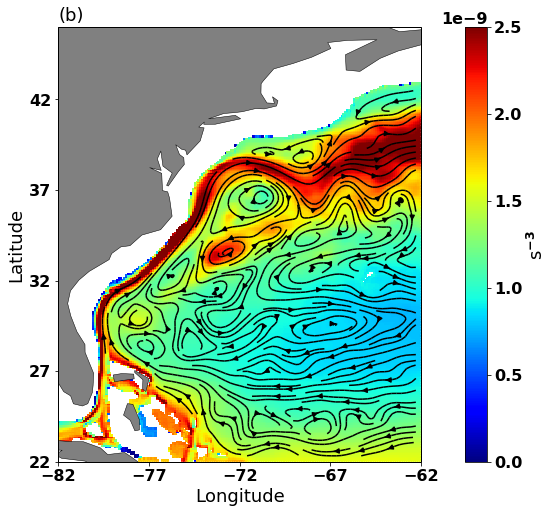

In [38]:
fig=plt.figure(figsize=(16,8))
ax0=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
ax0.streamplot(X,Y,umean.values,vmean.values,density=2.5,color='k',linewidth=1.5)
p=pv.mean('time').sel(st_ocean=d,method='nearest').plot(cmap='jet',add_colorbar=False,vmax=2.5e-9,vmin=0)
#plt.title('time-mean PV and streamline')
cb=plt.colorbar(p)
cb.ax.set_ylabel('s$^{-3}$',fontsize=18)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
#savefigure('pvandsl_gfsbad')

In [39]:
PV_DS=whole_pv(u,v,w,pv)

Text(0.5, 1.0, 'Whole PV change')

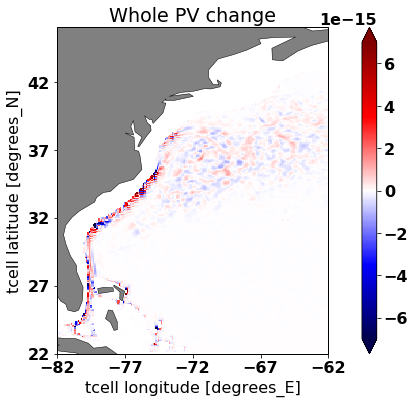

In [45]:
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(gsx.start,gsx.stop+1,5),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(gsy.start,gsy.stop+1,5),crs=ccrs.PlateCarree())
p1=PV_DS.sel(st_ocean=d,method='nearest').sel(xt_ocean=gsx).sel(yt_ocean=gsy).plot(cmap='seismic',vmin=-7e-15,vmax=7e-15)
plt.title('Whole PV change')                                                               

In [46]:
PV_DS_mean=meands_pv_mf(u,v,w,pv)
PV_var=PV_DS-PV_DS_mean

In [48]:
PV_DS_mean['LON']=PV_DS_mean['xt_ocean']+360
PV_var['LON']=PV_var['xt_ocean']+360
PV_DS['LON']=PV_DS['xt_ocean']+360

Text(0, 0.5, 's$^{-4}$')

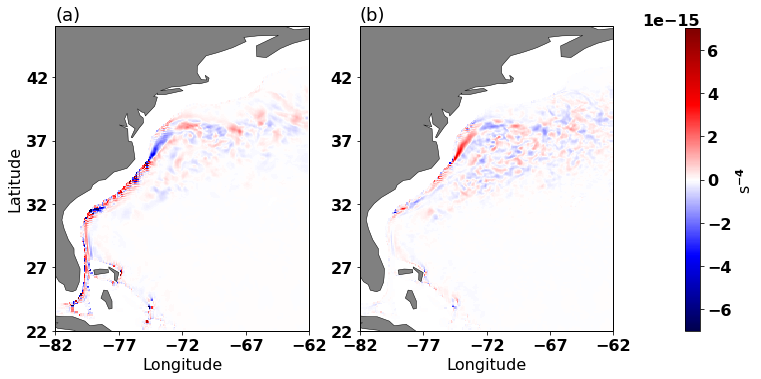

In [49]:
fig=plt.figure(figsize=(10,6))
ax0=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
PV_DS_mean.sel(st_ocean=d,method='nearest')\
          .plot(x='LON',y='yt_ocean',
                cmap='seismic',vmin=-7e-15,vmax=7e-15,add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('Latitude',fontsize=16)
plt.title('')
plt.title('(a)',loc='left',fontsize=18)


ax0=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax0.set_extent(region, crs=ccrs.PlateCarree())
ax0.add_feature(land)
ax0.set_xticks(np.arange(gsx.start,gsx.stop+1,5), crs=ccrs.PlateCarree())
ax0.set_yticks(np.arange(gsy.start,gsy.stop+1,5), crs=ccrs.PlateCarree())
p1=PV_var.sel(st_ocean=400,method='nearest')\
         .plot(x='LON',y='yt_ocean',cmap='seismic',vmin=-7e-15,vmax=7e-15,add_colorbar=False)
plt.xlabel('Longitude',fontsize=16)
plt.ylabel('',fontsize=16)
plt.title('')
plt.title('(b)',loc='left',fontsize=18)

cbar_ax=fig.add_axes([1,0.15,0.02,0.7])
cb=plt.colorbar(p1,cax=cbar_ax)
cb.ax.set_ylabel('s$^{-4}$',fontsize=16)
#savefigure('dspvcom_GFS')

## Every 4 year segment

In [29]:
time=slice('1985-01-01','2018-01-01')
u,v,w,pv=input_pv(time)

loading u...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
loading v...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl
loading w...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_wt_None_days-since-0001-01-01_None_False.pkl
loading pv...
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_vert_pv_None_days-since-0001-01-01_None_False.pkl


In [28]:
times = [pd.to_datetime('1985', format='%Y')+pd.DateOffset(years=y) for y in range(0,34,4)]
tranges = list(zip(times[0:-1], times[1:]))
#tranges.append((times[0],times[-1]))  # also include range covering all requested time ranges

yearranges = [str(pd.to_datetime(t[0]).year)+'-'+str(pd.to_datetime(t[1]).year-1) for t in tranges]
tslices = {y:slice(*t) for y,t in zip(yearranges,tranges)}
tsliceall = slice(min(min(tranges)), max(max(tranges))) 

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 1 in 9
plotting 2 in 9


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


plotting 3 in 9
plotting 4 in 9
plotting 5 in 9
plotting 6 in 9
plotting 7 in 9
plotting 8 in 9
plotting 9 in 9


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


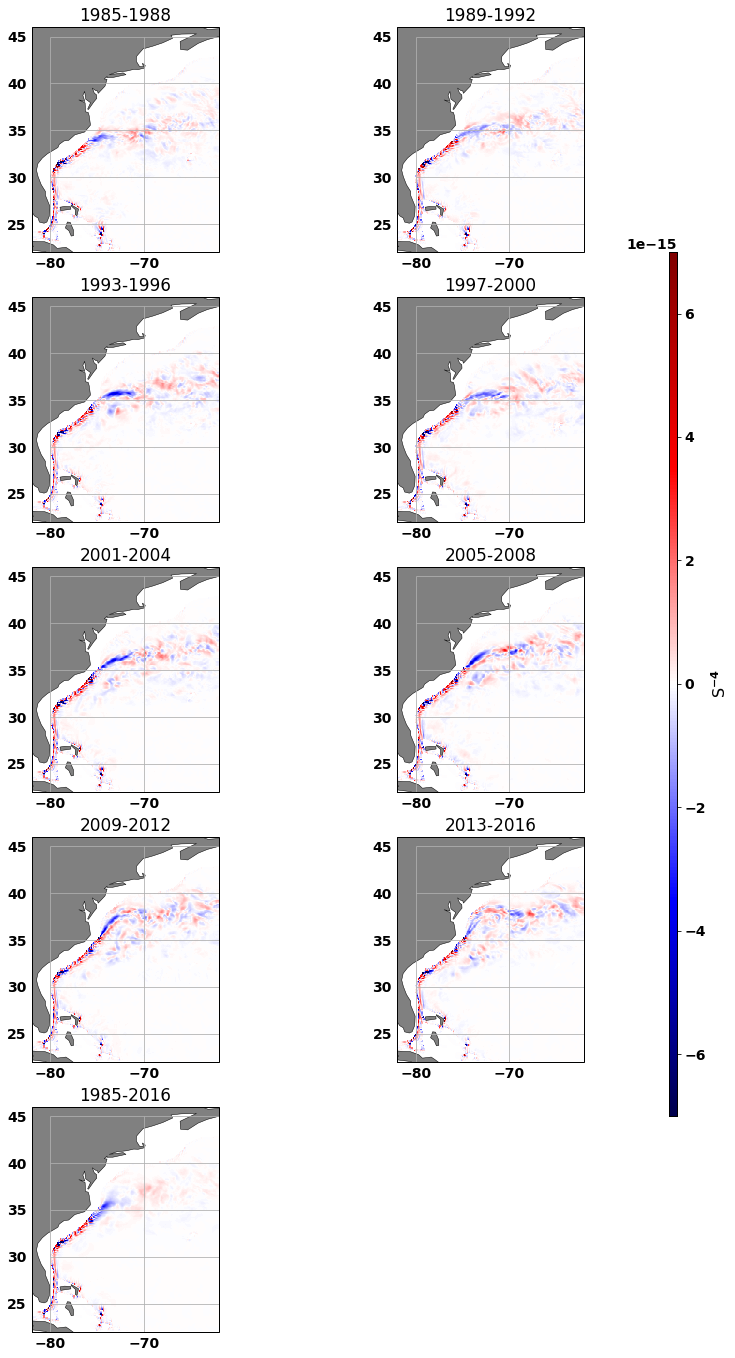

In [9]:
fig=plt.figure(figsize=(12,24))
#clev=np.arange(-7e-15,7e-15,1e-16)
for i, (yr,t) in enumerate(tslices.items()):
    u1=u.sel(time=t)
    v1=v.sel(time=t)
    w1=w.sel(time=t)
    pv1=pv.sel(time=t)
    PV_DS_mean=meands_pv_mf(u1,v1,w1,pv1)
    print('plotting',i+1,'in',len(tslices.items()))
    ax=plt.subplot(5,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land)
    ax.set_extent([-82,-62, 22,46],crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(-80, -59, 10)) 
    gl.ylocator = mticker.FixedLocator(range(20, 46, 5)) 
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=PV_DS_mean.sel(st_ocean=400,method='nearest').plot(cmap='seismic', vmin=-7e-15,
                                                          vmax=7e-15,add_colorbar=False,
                                                          transform=ccrs.PlateCarree())
    plt.title(yr)
    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('S$^{-4}$',fontsize=16)
savefigure('downstreampv_gulfstream')

Text(0.5, 1.0, 'PV tendency')

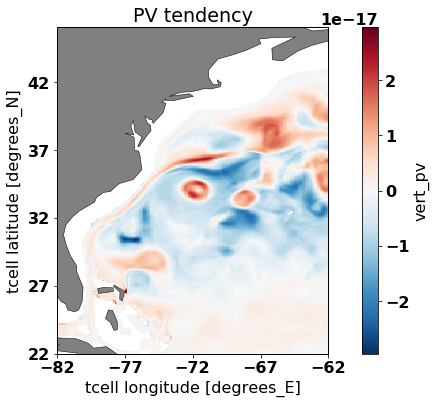

In [31]:
# check pv tendency
warnings.filterwarnings('ignore')
pvsel=pv.sel(time=slice('1993-01-01','1997-01-01'))
pv_diff=(pvsel.isel(time=-1)-pvsel.isel(time=0)).sel(st_ocean=400,method='nearest')
pv_tend=pv_diff/(1461*24*3600)
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land)
ax.set_extent(region,crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(gsx.start,gsx.stop+1,5),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(gsy.start,gsy.stop+1,5),crs=ccrs.PlateCarree())
p1=pv_tend.sel(xt_ocean=gsx).sel(yt_ocean=gsy).plot()
plt.title('PV tendency')

### Add streamlines

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 1 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 2 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 3 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 4 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 5 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 6 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 7 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


plotting 8 in 8


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


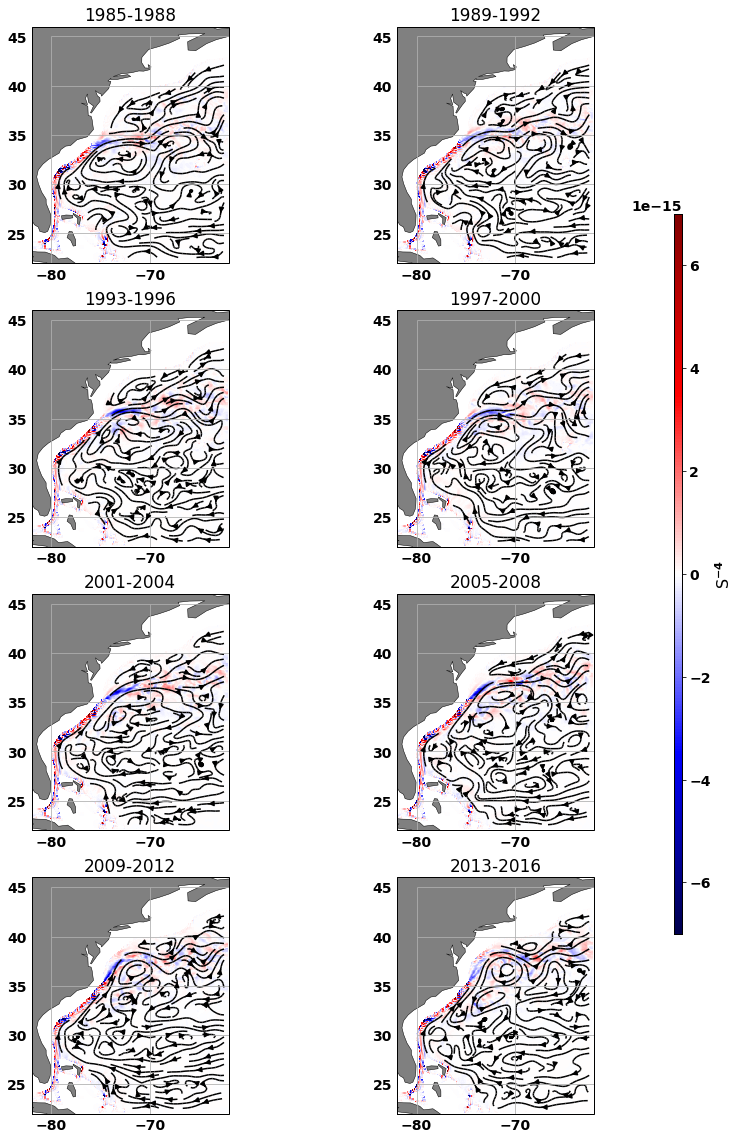

In [13]:
fig=plt.figure(figsize=(12,20))
#clev=np.arange(-7e-15,7e-15,1e-16)
for i, (yr,t) in enumerate(tslices.items()):
    u1=u.sel(time=t)
    v1=v.sel(time=t)
    w1=w.sel(time=t)
    pv1=pv.sel(time=t)
    umean=u1.mean('time').sel(st_ocean=d,method='nearest')
    vmean=v1.mean('time').sel(st_ocean=d,method='nearest')
    X,Y=np.meshgrid(umean['xu_ocean'].values,umean['yu_ocean'].values)
    PV_DS_mean=meands_pv_mf(u1,v1,w1,pv1)
    print('plotting',i+1,'in',len(tslices.items()))
    ax=plt.subplot(4,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land)
    ax.set_extent([-82,-62, 22,46],crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(-80, -59, 10)) 
    gl.ylocator = mticker.FixedLocator(range(20, 46, 5)) 
    gl.xlabels_top = False
    gl.ylabels_right = False
    ax.streamplot(X,Y,umean.values,vmean.values,density=1.5,color='k',linewidth=1.5)
    p1=PV_DS_mean.sel(st_ocean=400,method='nearest').plot(cmap='seismic', vmin=-7e-15,
                                                          vmax=7e-15,add_colorbar=False,
                                                          transform=ccrs.PlateCarree())
    plt.title(yr)
    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('S$^{-4}$',fontsize=16)
savefigure('downstreampv_gulfstream')